# Audio Transforms and Visualizations

Data visualization and transfomation is an important part of every model. Now that we have our dataset downloaded and yes/no labels parsed out. Lets learn more about audio data visualization and transforming this dataset. TorchAudio has many [transforms available](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html#transformations) in the library. Take a look at the list below to see the ever growing list of supported transformations. From this list we are going to take a deeper look at understanding the following concepts and transforms: `Spectrogram`, `MelSpectrogram`, `Waveform`, `STFT` and `MFCC`. Once we understand these concepts we will create our spectorgram images of the yes/no dataset to be used in the computer vision model.

- Resample: Resample waveform to a different sample rate.
- Spectrogram: Create a spectrogram from a waveform.
- GriffinLim: Compute waveform from a linear scale magnitude spectrogram using the Griffin-Lim transformation.
- ComputeDeltas: Compute delta coefficients of a tensor, usually a spectrogram.
- ComplexNorm: Compute the norm of a complex tensor.
- MelScale: This turns a normal STFT into a Mel-frequency STFT, using a conversion matrix.
- AmplitudeToDB: This turns a spectrogram from the power/amplitude scale to the decibel scale.
- MFCC: Create the Mel-frequency cepstrum coefficients from a waveform.
- MelSpectrogram: Create MEL Spectrograms from a waveform using the STFT function in PyTorch.
- MuLawEncoding: Encode waveform based on mu-law companding.
- MuLawDecoding: Decode mu-law encoded waveform.
- TimeStretch: Stretch a spectrogram in time without modifying pitch for a given rate.
- FrequencyMasking: Apply masking to a spectrogram in the frequency domain.
- TimeMasking: Apply masking to a spectrogram in the time domain.

## Load the Dataset Folders into a DataLoader

Here we import the packages and create a `load_audio_files` function to load audio files from a specificed path into a [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [21]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [36]:
def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
        #print(f'{waveform}, {sample_rate}, {label}, {speaker_id}, {utterance_number}')
        
    #Load dataset to DataLoader
    #trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
        
    return dataset

- Call the `load_audio_files` function for each class we are going to use, thne print the length of the dataset.

In [37]:
trainset_speechcommands_yes = load_audio_files('.\\data\\SpeechCommands\\speech_commands_v0.02\\yes', 'yes')
trainset_speechcommands_no = load_audio_files('.\\data\\SpeechCommands\\speech_commands_v0.02\\no', 'no')

In [38]:
print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 4044
Length of no dataset: 3941


In [39]:
trainloader_yes = torch.utils.data.DataLoader(trainset_speechcommands_yes, batch_size=1,
                                            shuffle=True, num_workers=0)

In [40]:
trainloader_no = torch.utils.data.DataLoader(trainset_speechcommands_no, batch_size=1,
                                            shuffle=True, num_workers=0)

- Here we grab the waveform and sample_rate from each class and print out a sample of the dataset to see what our data looks like.

In [46]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]}')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714
No Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
No Sample Rate: 16000
No Label: no
No ID: 012c8314


## Transform and Visualize

Our data is ready! Lets breakdown some of the audio transforms and visualization to better understand what they are and what they tell us about the data.


### Waveform

We talked about the waveform a little bit earlier but lets dive in a bit deeper.

In [47]:
def show_waveform(waveform, sample_rate, label):
    print("Waveform: {}\nSample rate: {}\nLabels: {}".format(waveform, sample_rate, label))
    new_sample_rate = sample_rate/10
    print(new_sample_rate)
    # Since Resample applies to a single channel, we resample first channel here
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

    print("Shape of transformed waveform: {}".format(waveform_transformed.size()))

    plt.figure()
    plt.plot(waveform_transformed[0,:].numpy())

Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Sample rate: 16000
Labels: yes
1600.0
Shape of transformed waveform: torch.Size([1, 1600])


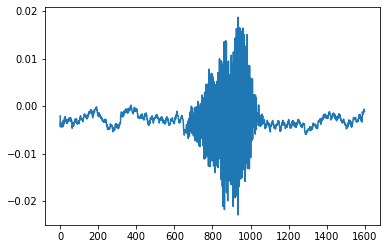

In [48]:
show_waveform(yes_waveform, yes_sample_rate, 'yes')

## Spectrogram



In [14]:
def show_spectrogram(waveform):
    spectrogram = torchaudio.transforms.Spectrogram()(waveform)
    #print(spectrogram)
    print("Shape of spectrogram: {}".format(spectrogram.size()))

    plt.figure()
    plt.imshow(spectrogram.log2()[0,:,:].numpy(), cmap='gray')
    #plt.imsave(f'test/spectrogram_img.png', spectrogram.log2()[0,:,:].numpy(), cmap='gray')
    

Shape of spectrogram: torch.Size([1, 201, 81])


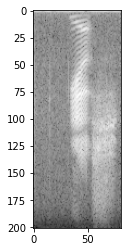

In [15]:
show_spectrogram(yes_waveform)

## Mel Spectrogram

In [16]:
def show_melspectrogram(waveform,sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='gray')
    #plt.imsave(f'test/mfcc_img.png', mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([1, 128, 81])


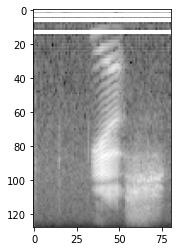

In [17]:
show_melspectrogram(yes_waveform, yes_sample_rate)

## Mfcc

In [18]:
def show_mfcc(waveform,sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='gray')
    #plt.imsave(f'test/mfcc_img.png', mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([1, 40, 81])


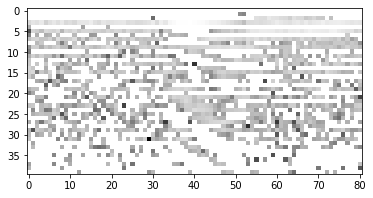

In [19]:
show_mfcc(yes_waveform, yes_sample_rate)

## Create Image from Spectrogram

In [ ]:
spectorgram_train = [];

def create_images(trainloader, label_dir):
    #make directory
    os.makedirs(f'./data/spectrograms/{label_dir}/', mode=0o777, exist_ok=True)
    
    for i, data in enumerate(trainloader):

        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        ID = data[3]

        #print("Waveform: {}\nSample rate: {}\nLabels: {} \nID:{}".format(waveform, sample_rate, label, ID))

        # create transformed waveforms
        spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)

        fig = plt.figure()
        plt.imsave(f'./data/spectrograms/{label_dir}/spec_img{i}.png', spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap='gray')

        spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])


In [ ]:
create_images(trainloader_yes, 'yes')
create_images(trainloader_no, 'no')